# IFT-3700 Travail 1

Félix Adam

Mehdi Aqdim

Maxime Daigle

Jonathan Graveline

In [33]:
#A enlever pour la remise
import dill
dill.dump_session('notebook_env.db')

In [ ]:
dill.load_session('notebook_env.db')

## Préparation

In [4]:
import numpy as np
import random as rand
import time
import matplotlib.pyplot as plt
import scipy.stats as stats
import warnings #remove warning from scipy.stats
warnings.filterwarnings("ignore", category=RuntimeWarning) 
seed = np.random.RandomState(seed=3)
%matplotlib inline

#Mettre 'skiprows=1' pour avoir toutes les données.

#take multiple size of training dataset (1000, 5000, 10000) and test (500, 1000, 1500)
multiple_train_data = []
multiple_train_label = []
multiple_test_data = []
multiple_test_label = []

training_size = [59001, 55001, 50001]
test_size = [9501, 9001,8501]

for i in range(len(training_size)):
    mnist_train = np.loadtxt('mnist_train.csv', dtype='int', delimiter=',', skiprows=training_size[i])
    mnist_test  = np.loadtxt('mnist_test.csv', dtype='int', delimiter=',', skiprows=test_size[i])

    train_label = mnist_train[:,0]
    train_data  = mnist_train[:,1:]

    test_label  = mnist_test[:,0]
    test_data   = mnist_test[:,1:]

    multiple_train_data.append(train_data)
    multiple_train_label.append(train_label)
    multiple_test_data.append(test_data)
    multiple_test_label.append(test_label)


#simple dataset
mnist_train = np.loadtxt('mnist_train.csv', dtype='int', delimiter=',', skiprows=59001)
mnist_test  = np.loadtxt('mnist_test.csv', dtype='int', delimiter=',', skiprows=9501)

train_label = mnist_train[:,0]
train_data  = mnist_train[:,1:]

test_label  = mnist_test[:,0]
test_data   = mnist_test[:,1:]

## Mesures

In [5]:
# distance euclidien
from sklearn.metrics import euclidean_distances

#Procrustes analysis
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.procrustes.html
from scipy.spatial import procrustes

def procrustes_similarity(u,v):
    #u and v are vectors
    # return disparity score between u and v
    u = u.reshape(u.shape[0],1)
    v = v.reshape(v.shape[0],1)
    return procrustes(u,v)[2]

def procrustes_matrix(X):
    # X is a matrix nxd with n vectors
    # return distance matrix nxn where distance [i,j] is the distance between X[i] and X[j]
    #environ 80 secondes pour creer une matrice (1000,1000)
    result = np.zeros((X.shape[0],X.shape[0]))
    for i in range(X.shape[0]):
        for j in range(i, X.shape[0]):
            result[i,j] = result[j,i] = procrustes_similarity(X[i],X[j])
    return result


# Notre mesure inspiré de procrustes
# https://github.com/scipy/scipy/blob/v1.1.0/scipy/spatial/_procrustes.py#L17-L132
from scipy.linalg.decomp_svd import svd

def procrustes_modified(data1, data2):
    mtx1 = np.array(data1, dtype=np.double, copy=True)
    mtx2 = np.array(data2, dtype=np.double, copy=True)

    if mtx1.ndim != 2 or mtx2.ndim != 2:
        raise ValueError("Input matrices must be two-dimensional")
    if mtx1.shape != mtx2.shape:
        raise ValueError("Input matrices must be of same shape")
    if mtx1.size == 0:
        raise ValueError("Input matrices must be >0 rows and >0 cols")
        
    norm1 = np.linalg.norm(mtx1)
    norm2 = np.linalg.norm(mtx2)

    if norm1 == 0 or norm2 == 0:
        raise ValueError("Input matrices must contain >1 unique points")

    # change scaling of data (in rows) such that trace(mtx*mtx') = 1
    mtx1 /= norm1
    mtx2 /= norm2
    
    # measure the dissimilarity between the two datasets
    disparity = np.sum(np.square(mtx1 - mtx2))

    return mtx1, mtx2, disparity

def procrustes_similarity_modified(u,v):
    #u and v are vectors
    # return disparity score between u and v
    u = u.reshape(u.shape[0],1)
    v = v.reshape(v.shape[0],1)
    return procrustes_modified(u,v)[2]

def procrustes_matrix_modified(X):
    # X is a matrix nxd with n vectors
    # return distance matrix nxn where distance [i,j] is the distance between X[i] and X[j]
    result = np.zeros((X.shape[0],X.shape[0]))
    for i in range(X.shape[0]):
        for j in range(i, X.shape[0]):
            result[i,j] = result[j,i] = procrustes_similarity_modified(X[i],X[j])
    return result

## Implémentation des algorithmes

#### KNN

In [31]:
from sklearn.neighbors import KNeighborsClassifier as knn

# # exemple d'utilisation 
# knn_default = knn(n_neighbors=7, metric='euclidean', n_jobs=6)
# knn_default.fit(train_data, train_label)
# result = knn_default.score(test_data, test_label)
# print("Taux de succès avec knn et la distance euclidienne: %.4f %%" % (result * 100.0))

#### Partition binaire

#### K-medoids

In [51]:
# modified code 
# from https://github.com/terkkila/scikit-learn/blob/kmedoids/sklearn/cluster/k_medoids_.py 
# and some functions from
# https://github.com/scikit-learn/scikit-learn/blob/bac89c253b35a8f1a3827389fbee0f5bebcbc985/sklearn/base.py
# are added to it

# # exemple d'utilisation
# kmedoids = KMedoids(n_clusters=10, distance_metric='euclidean', random_state=None)
# kmedoids.fit(train_data)
# result = kmedoids.score(test_data, test_label)
# print("Taux de succès avec k-medoids et la distance Euclidienne: %.4f %%" % (result * 100.0))



#___________________________________________________________
#K-medoids clustering

# Authors: Timo Erkkilä <timo.erkkila@gmail.com>
#          Antti Lehmussola <antti.lehmussola@gmail.com>
# License: BSD 3 clause

import numpy as np
import warnings

from sklearn.base import BaseEstimator, ClusterMixin, TransformerMixin
from sklearn.metrics.pairwise import PAIRWISE_DISTANCE_FUNCTIONS
from sklearn.utils import check_array, check_random_state
from sklearn.utils.validation import check_is_fitted


class KMedoids(BaseEstimator, ClusterMixin, TransformerMixin):
    """
    k-medoids class.
    Parameters
    ----------
    n_clusters : int, optional, default: 8
        How many medoids. Must be positive.
    distance_metric : string, optional, default: 'euclidean'
        What distance metric to use.
    clustering : {'pam'}, optional, default: 'pam'
        What clustering mode to use.
    init : {'random', 'heuristic'}, optional, default: 'heuristic'
        Specify medoid initialization.
    max_iter : int, optional, default : 300
        Specify the maximum number of iterations when fitting.
    random_state : int, optional, default: None
        Specify random state for the random number generator.
    """

    # Supported clustering methods
    CLUSTERING_METHODS = ['pam']

    # Supported initialization methods
    INIT_METHODS = ['random', 'heuristic']

    def __init__(self, n_clusters=8, distance_metric='euclidean',
                 clustering_method='pam', init='heuristic',
                 max_iter=300, random_state=None, procrustes_type = None):

        self.n_clusters = n_clusters

        self.distance_metric = distance_metric

        self.init = init

        self.max_iter = max_iter

        self.clustering_method = clustering_method

        self.random_state = random_state
        
        self.procrustes_type = procrustes_type

    def _check_init_args(self):

        # Check n_clusters
        if self.n_clusters is None or self.n_clusters <= 0 or \
                not isinstance(self.n_clusters, int):
            raise ValueError("n_clusters has to be nonnegative integer")

        # Check distance_metric
        if callable(self.distance_metric):
            self.distance_func = self.distance_metric
        elif self.distance_metric in PAIRWISE_DISTANCE_FUNCTIONS:
            self.distance_func = \
                PAIRWISE_DISTANCE_FUNCTIONS[self.distance_metric]
        else:
            raise ValueError("distance_metric needs to be " +
                             "callable or one of the " +
                             "following strings: " +
                             "{}".format(PAIRWISE_DISTANCE_FUNCTIONS.keys()) +
                             ". Instead, '{}' ".format(self.distance_metric) +
                             "was given.")

        # Check clustering_method
        if self.clustering_method not in self.CLUSTERING_METHODS:
            raise ValueError("clustering must be one of the following: " +
                             "{}".format(self.CLUSTERING_METHODS))

        # Check init
        if self.init not in self.INIT_METHODS:
            raise ValueError("init needs to be one of " +
                             "the following: " +
                             "{}".format(self.INIT_METHODS))

        # Check random state
        self.random_state_ = check_random_state(self.random_state)

    def fit(self, X, y=None):
        """Fit K-Medoids to the provided data.
        Parameters
        ----------
        X : array-like or sparse matrix, shape=(n_samples, n_features)
        Returns
        -------
        self
        """

        self._check_init_args()

        # Check that the array is good and attempt to convert it to
        # Numpy array if possible
        X = self._check_array(X)

        # Apply distance metric to get the distance matrix
        D = self.distance_func(X)

        medoid_ics = self._get_initial_medoid_indices(D, self.n_clusters)

        # Old medoids will be stored here for reference
        old_medoid_ics = np.zeros((self.n_clusters,))

        # Continue the algorithm as long as
        # the medoids keep changing and the maximum number
        # of iterations is not exceeded
        self.n_iter_ = 0
        while not np.all(old_medoid_ics == medoid_ics) and \
                self.n_iter_ < self.max_iter:

            self.n_iter_ += 1

            # Keep a copy of the old medoid assignments
            old_medoid_ics = np.copy(medoid_ics)

            # Get cluster indices
            cluster_ics = self._get_cluster_ics(D, medoid_ics)

            # Update medoids with the new cluster indices
            self._update_medoid_ics_in_place(D, cluster_ics, medoid_ics)

        # Expose labels_ which are the assignments of
        # the training data to clusters
        self.labels_ = cluster_ics

        # Expose cluster centers, i.e. medoids
        self.cluster_centers_ = X.take(medoid_ics, axis=0)

        # Return self to enable method chaining
        return self

    def _check_array(self, X):

        X = check_array(X)

        # Check that the number of clusters is less than or equal to
        # the number of samples
        if self.n_clusters > X.shape[0]:
            raise ValueError("The number of medoids " +
                             "({}) ".format(self.n_clusters) +
                             "must be larger than the number " +
                             "of samples ({})".format(X.shape[0]))

        return X

    def _get_cluster_ics(self, D, medoid_ics):
        """Returns cluster indices for D and current medoid indices"""

        # Assign data points to clusters based on
        # which cluster assignment yields
        # the smallest distance
        cluster_ics = np.argmin(D[medoid_ics, :], axis=0)

        return cluster_ics

    def _update_medoid_ics_in_place(self, D, cluster_ics, medoid_ics):
        """In-place update of the medoid indices"""

        # Update the medoids for each cluster
        for cluster_idx in range(self.n_clusters):

            if sum(cluster_ics == cluster_idx) == 0:
                warnings.warn("Cluster {} is empty!".format(cluster_idx))
                continue

            # Find current cost that is associated with cluster_idx.
            # Cost is the sum of the distance from the cluster
            # members to the medoid.
            curr_cost = np.sum(D[medoid_ics[cluster_idx],
                                 cluster_ics == cluster_idx])

            # Extract the distance matrix between the data points
            # inside the cluster_idx
            D_in = D[cluster_ics == cluster_idx, :]
            D_in = D_in[:, cluster_ics == cluster_idx]

            # Calculate all costs there exists between all
            # the data points in the cluster_idx
            all_costs = np.sum(D_in, axis=1)

            # Find the index for the smallest cost in cluster_idx
            min_cost_idx = np.argmin(all_costs)

            # find the value of the minimum cost in cluster_idx
            min_cost = all_costs[min_cost_idx]

            # If the minimum cost is smaller than that
            # exhibited by the currently used medoid,
            # we switch to using the new medoid in cluster_idx
            if min_cost < curr_cost:

                # Find data points that belong to cluster_idx,
                # and assign the newly found medoid as the medoid
                # for cluster c
                medoid_ics[cluster_idx] = \
                    np.where(cluster_ics == cluster_idx)[0][min_cost_idx]

    def transform(self, X):
        """Transforms X to cluster-distance space.
        Parameters
        ----------
        X : array-like or sparse matrix, shape=(n_samples, n_features)
            Data to transform.
        Returns
        -------
        X_new : array, shape=(n_samples, n_clusters)
            X transformed in the new space.
        """

        check_is_fitted(self, "cluster_centers_")

        # Apply distance metric wrt. cluster centers (medoids),
        # and return these distances
        return self.distance_func(X, Y=self.cluster_centers_)

    def predict(self, X):

        check_is_fitted(self, "cluster_centers_")

        # Check that the array is good and attempt to convert it to
        # Numpy array if possible
        X = check_array(X)

        # Apply distance metric wrt. cluster centers (medoids)

        if self.procrustes_type is not None:
            D = np.zeros((X.shape[0], self.cluster_centers_.shape[0]))
            i = 0
            for u in X:
                j = 0
                for v in self.cluster_centers_:
                    if self.procrustes_type == 'normal':
                        D[i,j] = procrustes_similarity(u,v)
                    elif self.procrustes_type == 'modified':
                        D[i,j] = procrustes_similarity_modified(u,v)
                    j = j+1
                i= i+1
        else: 
            D = self.distance_func(X, Y=self.cluster_centers_)

        # Assign data points to clusters based on
        # which cluster assignment yields
        # the smallest distance
        labels = np.argmin(D, axis=1)

        return labels
    #__________________________
    #ADD
    #________________________
    def score(self, X, y, sample_weight=None):
        """Returns the mean accuracy on the given test data and labels.
        In multi-label classification, this is the subset accuracy
        which is a harsh metric since you require for each sample that
        each label set be correctly predicted.
        Parameters
        ----------
        X : array-like, shape = (n_samples, n_features)
            Test samples.
        y : array-like, shape = (n_samples) or (n_samples, n_outputs)
            True labels for X.
        sample_weight : array-like, shape = [n_samples], optional
            Sample weights.
        Returns
        -------
        score : float
            Mean accuracy of self.predict(X) wrt. y.
        """
        from sklearn.metrics import accuracy_score
        return accuracy_score(y, self.predict(X), sample_weight=sample_weight)

    def inertia(self, X):

        # Map the original X to the distance-space
        Xt = self.transform(X)

        # Define inertia as the sum of the sample-distances
        # to closest cluster centers
        inertia = np.sum(np.min(Xt, axis=1))

        return inertia

    def _get_initial_medoid_indices(self, D, n_clusters):

        if self.init == 'random':  # Random initialization

            # Pick random k medoids as the initial ones.
            medoids = self.random_state_.permutation(D.shape[0])[:n_clusters]

        elif self.init == 'heuristic':  # Initialization by heuristic

            # Pick K first data points that have the smallest sum distance
            # to every other point. These are the initial medoids.
            medoids = list(np.argsort(np.sum(D, axis=1))[:n_clusters])

        else:

            raise ValueError("Initialization not implemented for method: " +
                             "'{}'".format(self.init))

        return medoids

#### PCoA

In [6]:
from sklearn.manifold import MDS

# # exemple d'utilisation
# # PCoA reducing to 2 dimensions
# pcoa_2d = MDS(n_components=2, random_state=seed, dissimilarity="precomputed", n_jobs=-1)
# similarities_euclidean = euclidean_distances(train_data)
# pos_euclidean = pcoa_2d.fit(similarities_euclidean).embedding_

#PCoA reducing to 2 dimensions
pcoa_2d = MDS(n_components=2, random_state=seed, dissimilarity="precomputed", n_jobs=-1)
#PCoA reducing to 3 dimensions
pcoa_3d = MDS(n_components=3, random_state=seed, dissimilarity="precomputed", n_jobs=-1)
#PCoA reducing to 50 dimensions
pcoa_50d = MDS(n_components=50, random_state=seed, dissimilarity="precomputed", n_jobs=-1)
#PCoA reducing to 100 dimensions
pcoa_100d = MDS(n_components=100, random_state=seed, dissimilarity="precomputed", n_jobs=-1)

pcoas = [pcoa_2d,pcoa_3d,pcoa_50d,pcoa_100d]
pcoas_dim = ['2d','3d','50d','100d']

#### Isomap

In [9]:
# Modified isomap from scikit learn to be able to change the metric used
# https://github.com/scikit-learn/scikit-learn/blob/bac89c2/sklearn/manifold/isomap.py#L15

# # exemple d'utilisation
# # Isomap reduisant à 2d
# iso_2d = Isomap(n_components=2, n_jobs=-1)
# iso_pos_euclidean = iso_2d.fit_transform(train_data, metric = 'euclidean')


#_______________________________________-
#Isomap for manifold learning

# Author: Jake Vanderplas  -- <vanderplas@astro.washington.edu>
# License: BSD 3 clause (C) 2011

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.neighbors import NearestNeighbors, kneighbors_graph
from sklearn.utils import check_array
from sklearn.utils.graph import graph_shortest_path
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import KernelCenterer

#_____________________________
# ____________ADDED___________
#_____________________________
""" 
It is now possible to specify the metric use in fit_transform()


metric : string or callable, default ‘minkowski’
metric to use for distance computation. Any metric from scikit-learn or scipy.spatial.distance can be used.

If metric is a callable function, it is called on each pair of instances (rows) and the resulting value recorded. 
The callable should take two arrays as input and return one value indicating the distance between them. 
This works for Scipy’s metrics, but is less efficient than passing the metric name as a string.

Distance matrices are not supported.

Valid values for metric are:
from scikit-learn: [‘cityblock’, ‘cosine’, ‘euclidean’, ‘l1’, ‘l2’, ‘manhattan’]
from scipy.spatial.distance: [‘braycurtis’, ‘canberra’, ‘chebyshev’, ‘correlation’, ‘dice’, ‘hamming’, ‘jaccard’, 
                              ‘kulsinski’, ‘mahalanobis’, ‘minkowski’, ‘rogerstanimoto’, ‘russellrao’, ‘seuclidean’, 
                              ‘sokalmichener’, ‘sokalsneath’, ‘sqeuclidean’, ‘yule’]
"""


class Isomap(BaseEstimator, TransformerMixin):
    """Isomap Embedding
    Non-linear dimensionality reduction through Isometric Mapping
    Read more in the :ref:`User Guide <isomap>`.
    Parameters
    ----------
    n_neighbors : integer
        number of neighbors to consider for each point.
    n_components : integer
        number of coordinates for the manifold
    eigen_solver : ['auto'|'arpack'|'dense']
        'auto' : Attempt to choose the most efficient solver
        for the given problem.
        'arpack' : Use Arnoldi decomposition to find the eigenvalues
        and eigenvectors.
        'dense' : Use a direct solver (i.e. LAPACK)
        for the eigenvalue decomposition.
    tol : float
        Convergence tolerance passed to arpack or lobpcg.
        not used if eigen_solver == 'dense'.
    max_iter : integer
        Maximum number of iterations for the arpack solver.
        not used if eigen_solver == 'dense'.
    path_method : string ['auto'|'FW'|'D']
        Method to use in finding shortest path.
        'auto' : attempt to choose the best algorithm automatically.
        'FW' : Floyd-Warshall algorithm.
        'D' : Dijkstra's algorithm.
    neighbors_algorithm : string ['auto'|'brute'|'kd_tree'|'ball_tree']
        Algorithm to use for nearest neighbors search,
        passed to neighbors.NearestNeighbors instance.
    n_jobs : int or None, optional (default=None)
        The number of parallel jobs to run.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.
    Attributes
    ----------
    embedding_ : array-like, shape (n_samples, n_components)
        Stores the embedding vectors.
    kernel_pca_ : object
        `KernelPCA` object used to implement the embedding.
    training_data_ : array-like, shape (n_samples, n_features)
        Stores the training data.
    nbrs_ : sklearn.neighbors.NearestNeighbors instance
        Stores nearest neighbors instance, including BallTree or KDtree
        if applicable.
    dist_matrix_ : array-like, shape (n_samples, n_samples)
        Stores the geodesic distance matrix of training data.
    Examples
    --------
    >>> from sklearn.datasets import load_digits
    >>> from sklearn.manifold import Isomap
    >>> X, _ = load_digits(return_X_y=True)
    >>> X.shape
    (1797, 64)
    >>> embedding = Isomap(n_components=2)
    >>> X_transformed = embedding.fit_transform(X[:100])
    >>> X_transformed.shape
    (100, 2)
    References
    ----------
    .. [1] Tenenbaum, J.B.; De Silva, V.; & Langford, J.C. A global geometric
           framework for nonlinear dimensionality reduction. Science 290 (5500)
    """
    
    def __init__(self, n_neighbors=5, n_components=2, eigen_solver='auto',
                 tol=0, max_iter=None, path_method='auto',
                 neighbors_algorithm='auto', n_jobs=None):
        self.n_neighbors = n_neighbors
        self.n_components = n_components
        self.eigen_solver = eigen_solver
        self.tol = tol
        self.max_iter = max_iter
        self.path_method = path_method
        self.neighbors_algorithm = neighbors_algorithm
        self.n_jobs = n_jobs

    ##_____________________________
    ##added metric = ''minkowski'
    ##_____________________________
    def _fit_transform(self, X, metric = 'minkowski'):
        X = check_array(X, accept_sparse='csr')
        
        ##__________________________________________________
        ##added metric=metric
        ##_________________________________________________
        self.nbrs_ = NearestNeighbors(n_neighbors=self.n_neighbors,
                                      algorithm=self.neighbors_algorithm,
                                      n_jobs=self.n_jobs, metric=metric)
        self.nbrs_.fit(X)
        self.training_data_ = self.nbrs_._fit_X
        self.kernel_pca_ = KernelPCA(n_components=self.n_components,
                                     kernel="precomputed",
                                     eigen_solver=self.eigen_solver,
                                     tol=self.tol, max_iter=self.max_iter,
                                     n_jobs=self.n_jobs)
        ##____________________________________________________
        ##added metric=metric
        ##____________________________________________________
        kng = kneighbors_graph(self.nbrs_, self.n_neighbors,
                               mode='distance', n_jobs=self.n_jobs, metric = metric)

        self.dist_matrix_ = graph_shortest_path(kng,
                                                method=self.path_method,
                                                directed=False)
        G = self.dist_matrix_ ** 2
        G *= -0.5

        self.embedding_ = self.kernel_pca_.fit_transform(G)

    def reconstruction_error(self):
        """Compute the reconstruction error for the embedding.
        Returns
        -------
        reconstruction_error : float
        Notes
        -------
        The cost function of an isomap embedding is
        ``E = frobenius_norm[K(D) - K(D_fit)] / n_samples``
        Where D is the matrix of distances for the input data X,
        D_fit is the matrix of distances for the output embedding X_fit,
        and K is the isomap kernel:
        ``K(D) = -0.5 * (I - 1/n_samples) * D^2 * (I - 1/n_samples)``
        """
        G = -0.5 * self.dist_matrix_ ** 2
        G_center = KernelCenterer().fit_transform(G)
        evals = self.kernel_pca_.lambdas_
        return np.sqrt(np.sum(G_center ** 2) - np.sum(evals ** 2)) / G.shape[0]

    def fit(self, X, y=None):
        """Compute the embedding vectors for data X
        Parameters
        ----------
        X : {array-like, sparse matrix, BallTree, KDTree, NearestNeighbors}
            Sample data, shape = (n_samples, n_features), in the form of a
            numpy array, precomputed tree, or NearestNeighbors
            object.
        y : Ignored
        Returns
        -------
        self : returns an instance of self.
        """
        self._fit_transform(X)
        return self

    ##_____________________________
    ##added metric = ''minkowski'
    ##_____________________________
    def fit_transform(self, X, y=None, metric = 'minkowski'):
        """Fit the model from data in X and transform X.
        Parameters
        ----------
        X : {array-like, sparse matrix, BallTree, KDTree}
            Training vector, where n_samples in the number of samples
            and n_features is the number of features.
        y : Ignored
        Returns
        -------
        X_new : array-like, shape (n_samples, n_components)
        """
        ##_____________________________
        ##added metric
        ##_____________________________
        self._fit_transform(X, metric)
        return self.embedding_

    def transform(self, X):
        """Transform X.
        This is implemented by linking the points X into the graph of geodesic
        distances of the training data. First the `n_neighbors` nearest
        neighbors of X are found in the training data, and from these the
        shortest geodesic distances from each point in X to each point in
        the training data are computed in order to construct the kernel.
        The embedding of X is the projection of this kernel onto the
        embedding vectors of the training set.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
        Returns
        -------
        X_new : array-like, shape (n_samples, n_components)
        """
        X = check_array(X)
        distances, indices = self.nbrs_.kneighbors(X, return_distance=True)

        # Create the graph of shortest distances from X to self.training_data_
        # via the nearest neighbors of X.
        # This can be done as a single array operation, but it potentially
        # takes a lot of memory.  To avoid that, use a loop:
        G_X = np.zeros((X.shape[0], self.training_data_.shape[0]))
        for i in range(X.shape[0]):
            G_X[i] = np.min(self.dist_matrix_[indices[i]] +
                            distances[i][:, None], 0)

        G_X **= 2
        G_X *= -0.5

        return self.kernel_pca_.transform(G_X)
    

# Isomap reduisant à 2d
iso_2d = Isomap(n_components=2, n_jobs=-1)
iso_3d = Isomap(n_components=3, n_jobs=-1)
iso_50d = Isomap(n_components=50, n_jobs=-1)
iso_100d = Isomap(n_components=100, n_jobs=-1)
isos = [iso_2d,iso_3d,iso_50d,iso_100d]
isos_dim = ['2d','3d','50d','100d']

#### Visualisation de la réduction de dimensionalité

In [10]:
def visualize_2d(pos,title):
    fig, ax = plt.subplots()
    colors=((1,0,0),(0,1,0),(0,0,1),(0.5,0.5,0),(0,0.5,0.5),(0.5,0,0.5),(0.4,0.6,0),(0.6,0.4,0),(0,0.6,0.4),(0.5,0.3,0.2),)
    for i in range(pos.shape[0]):
        ax.scatter(pos[i,0],pos[i,1],label = train_label[i],color=colors[train_label[i]])

    #remove duplicate in legend
    handles,labels=ax.get_legend_handles_labels()
    handles_unique, labels_unique = [],[]
    seen = set()
    for i,e in enumerate(labels):
        if e not in seen:
            seen.add(e)
            handles_unique.append(handles[i])
            labels_unique.append(e)
            if len(seen) == 10:
                break

    #sort legend
    labels_unique, handles_unique = (list(l) for l in zip(*sorted(zip(labels_unique, handles_unique))))

    plt.legend(handles_unique,labels_unique,loc="best")
    plt.title(title)
    plt.show()

#### Calcule du score de la réduction de dimensionalité

In [11]:
def dimensionality_reduction_score(ori,reduc):
    # ori: original distance matrix
    # reduc: distance matrix in the reduced space
   
    # return: average kendalltau distance between the orders in ori and reduc
 
    # if the result is closer to 1, the order of closeness between examples before and after the dimensionality reduction 
    # is the same (ie if example x was the closest to y in the orignal space, x is the closest to y in the reduced space)
    
    # if the result is closer to -1, it means that the closest example are now the farthest (ie x is the closest to y in the
    # original space, then x is the farthest to y in the reduced space)
    
    j=1
    result = 0
    # distance metric is symetric, want to ignore the lower triangle half of the matrice
    for i in range(reduc.shape[0]-1):
        if ori[i,j:].shape[0] != 1:
            t, _ = stats.kendalltau(ori[i,j:].argsort(), reduc[i,j:].argsort())
            result = result + t
            j = j+1
    return result / (j-1)

#### Performance évaluation de Isomap

In [12]:
def performane_iso(isos, isos_dim,train_data, metric_train, metric_score):
    iso_scores = []
    iso_times = []
    iso_visualize = []

    for j in range(len(isos)):
        start = time.time()
        iso_pos = isos[j].fit_transform(train_data, metric = metric_train)
        end = time.time()

        duration = end - start
        score = dimensionality_reduction_score(metric_score(train_data), metric_score(iso_pos))
        iso_visualize.append(iso_pos)
        iso_scores.append(score)
        iso_times.append(duration)

        print('Avec '+str(train_data.shape[0])+' exemples, réduction à ' + isos_dim[j])
        print("Score de la réduction de dimensionnalité: %.4f" % (score))
        print(duration, 'seconds')
        print()
    return iso_scores, iso_times, iso_visualize

## Présentation de la mesure choisie

Lors de la phase d'exploration, nous avons essayé de nombreuses mesures avec des résultats très variables. Par exemple, nous avons essayé la structural similarity index (SSIM)

In [9]:
from skimage.measure import compare_ssim as ssim
# http://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.compare_ssim

# mean structural similarity index between two images
start = time.time()
knn_ssim = knn(n_neighbors=7, metric=ssim, n_jobs=-1)
knn_ssim.fit(train_data, train_label)
result_ssim = knn_ssim.score(test_data, test_label)

end = time.time()
print("Taux de succès avec knn et structural similarity index: %.4f %%" % (result_ssim * 100.0))
print(end-start, 'seconds')

# Avec 5000 train example et 500 test example:
# Taux de succès avec knn et structural similarity index: 0.8000 %
# 1294.130733013153 seconds (22 minutes)

Taux de succès avec knn et structural similarity index: 0.8000 %
1294.130733013153 seconds


qui est très lent et qui obtient un résultat extrêmement mauvais. Comparativement à des conditions exactement pareilles excepté que c'est la distance euclidienne, la ssim prend environ 22 minutes sur 5000 exemples tandis que la version avec la distance euclidienne prend 0.24 secondes. De plus, la performance est de seulement 0.8% tandis que la distance euclidienne obtient 84.6%.

Nous avons aussi essayé de nombreuse mesure plus simple comme la distance cosine ou L3:

In [78]:
start = time.time()
knn_l3 = knn(n_neighbors=7, metric='minkowski', p=3, n_jobs=-1)
knn_l3.fit(train_data, train_label)
result_l3 = knn_l3.score(test_data, test_label)

end = time.time()
print("Taux de succès avec knn et L3: %.4f %%" % (result_l3 * 100.0))
print(end-start, 'seconds')

# Avec 10000 train examples et 1000 test examples:
# Taux de succès avec knn et L3: 95.5000 %
# 28.261430978775024 seconds

# Avec 5000 train examples et 500 test examples:
# Taux de succès avec knn et L3: 90.8000 %
# 6.961097002029419 seconds

# Avec 1000 train examples et 500 test examples:
# Taux de succès avec knn et L3: 85.4000 %
# 1.2310302257537842 seconds

Taux de succès avec knn et L3: 85.4000 %
1.2310302257537842 seconds


Cependant, malgré que les temps d'execution ne soient pas beaucoup plus long (ici environ 1 secondes de plus que l'euclidien), les résultats obtenus n'étaient pas très intéressant étant donné que le résultat n'étaient qu'une très faible amélioration (dans ce cas-ci une amélioration de 0.8% (de 84.6% à 85.4%)).

Finalement, la mesure trouvée qui nous a donné les résultats les plus intéressants est l'analyse procustéenne (Procrustes analysis, en anglais).

In [76]:
start = time.time()
knn_procrustes = knn(n_neighbors=7, metric=procrustes_similarity, n_jobs=-1)
knn_procrustes.fit(train_data, train_label)
result_procrustes = knn_procrustes.score(test_data, test_label)

end = time.time()
print("Taux de succès avec knn et Procrustes analysis comme similarité: %.4f %%" % (result_procrustes * 100.0))
print(end-start, 'seconds')

# Avec 10000 train examples et 1000 test examples:
# Taux de succès avec knn et Procrustes analysis comme similarité: 96.5000 %
# 2965.029656648636 seconds (49 minutes)

# Avec 5000 train example et 500 test example:
# Taux de succès avec knn et Procrustes analysis comme similarité: 92.6000 %
# 741.8232653141022 seconds (12 minutes)

# Avec 1000 train examples et 500 test examples:
# Taux de succès avec knn et Procrustes analysis comme similarité: 89.4000 %
# 126.29976058006287 seconds (2 minutes 6 secondes)

Taux de succès avec knn et Procrustes analysis comme similarité: 89.4000 %
126.29976058006287 seconds


Malgré que l'execution prend, dans cet exemple, 2 minutes 6 secondes tandis que la version euclidéenne prend seulement 0.24 secondes, nous obtenons une amélioration de presque 5% (de 84.6% à 89.4%).

L'idée de l'analyse procustéenne est la suivante:
"Elle est utilisée pour déformer un objet afin de le rendre autant que possible semblable à une référence (potentiellement arbitraire), ne laissant apparaître entre l'objet et la référence que les différences que les transformations autorisées (rotation, translation et mise à l'échelle) n'ont pu gommer. "
https://fr.wikipedia.org/wiki/Analyse_procustéenne

L'algorithme procède de la façon suivante enfin de réaliser cette idée:

1) il prend les points/coordonnées de deux objets
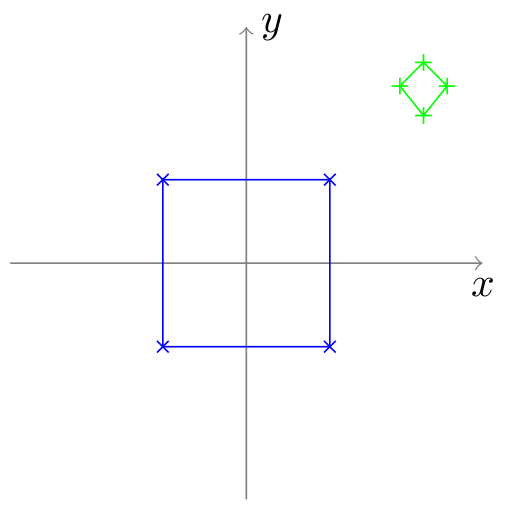


2) il supprime la composante de translation
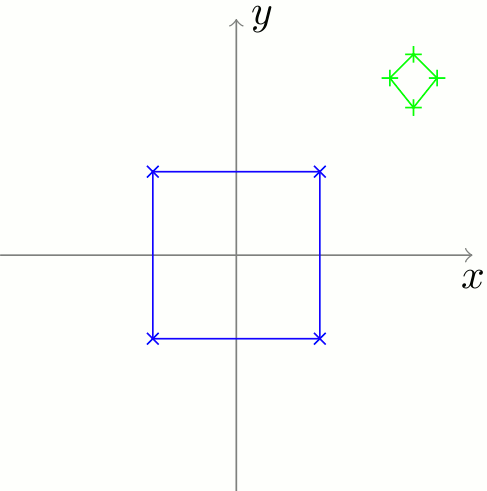


3) il supprime la composante d'échelle
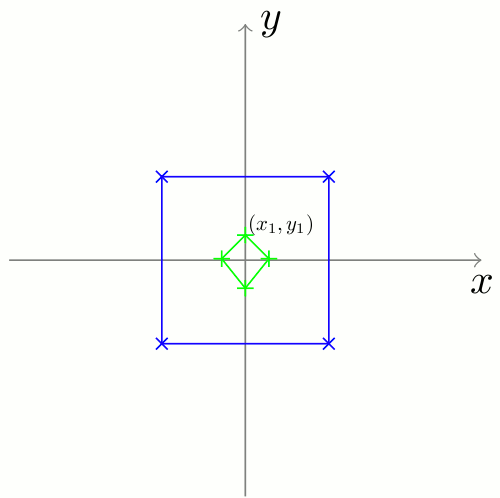

4) il supprime la composante de rotation
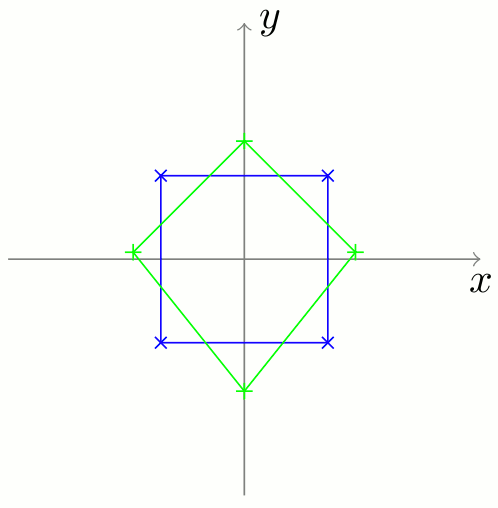


5) il calcule la différence restante entre les deux objets
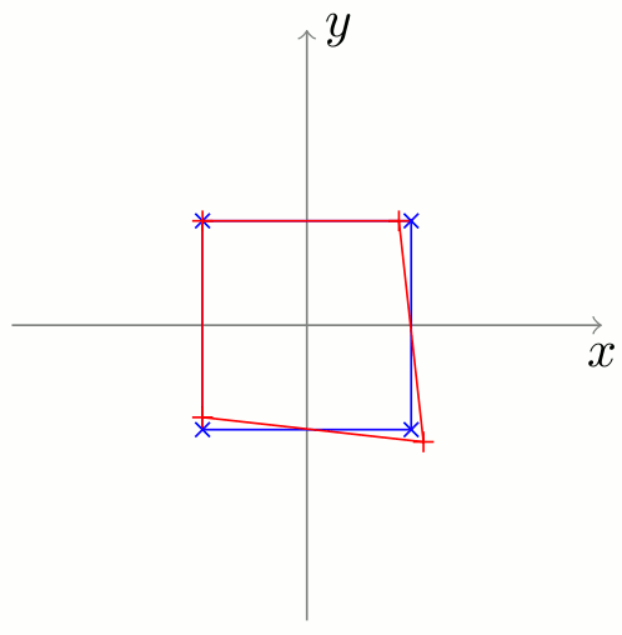

Cependant, les résultat intéressants obtenus lors de notre phase d'exploration ont été obtenus sur des données qui représente l'intensité (0 = noire, 255 = blanc) des pixels dans une image et pas avec des vecteurs représentant des points. Si nous regargons ce qui se passe réellement avec nos données lors de l'utilisation de procrustes:

In [10]:
def rotate_90(ex):
    # fait la rotation de 90 degrée de l'exemple ex
    n_ex = np.zeros(ex.shape)
    r = range(28)
    for i in r:
        for j in r:
            n_ex[27-j+i*28] = ex[i+j*28]
    return n_ex

def translate(ex, offx, offy):
    # fait la translation de l'exemple ex
    n_ex = np.zeros(ex.shape)
    r = range(28)
    for i in r:
        for j in r:
            x = min(max(0, i - offx), 27)
            y = min(max(0, j - offy), 27)
            n_ex[x+y*28] = ex[i+j*28]
    return n_ex

# Code provenant d'un des TPs
def show(ex):
    #Conversion de notre vecteur d'une dimension en 2 dimensions
    matrix = np.reshape(ex, (28,28))
    plt.imshow(matrix, cmap='gray')
    plt.show()

original


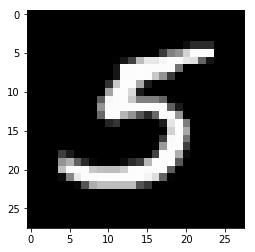

Translation de l'original


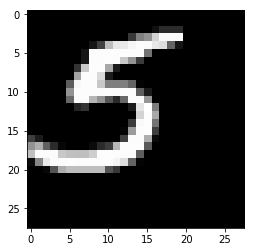

Tentative de procrustes de centré à l'origine


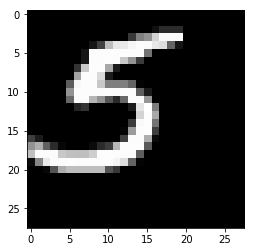

rotation de l'original


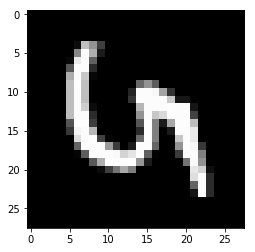

tentative de procrustes de supprimer la composante de rotation


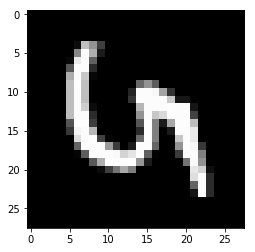

Mesure de dissimilarité obtenue:
	 l'original et l'original 0.0000
	 l'original et rotation de 90 degrés:    0.9980
	 l'original et translation de 3 pixels:  0.9980
	 l'original et les deux transformations: 0.9576


In [15]:
ex0 = train_data[2]
ex1 = translate(ex0, 4, 2)
data2 = ex1.reshape((784,1))

# From Procrustes:
# translate all the data to the origin
mtx2 = np.array(data2, dtype=np.double, copy=True)
mtx2 -= np.mean(mtx2, 0)

#impact de ce code sur mnist
print('original')
show(ex0)
print("Translation de l'original")
show(ex1)
print("Tentative de procrustes de centré à l'origine")
show(mtx2)

ex2 = rotate_90(ex0)
data1 = ex0.reshape((784,1))
data2 = ex2.reshape((784,1))

# From procrustes
mtx1 = np.array(data1, dtype=np.double, copy=True)
mtx2 = np.array(data2, dtype=np.double, copy=True)

A = mtx1
B = mtx2
# transform mtx2 to minimize disparity
u, w, vt = svd(B.T.dot(A).T)
R = u.dot(vt)
s = w.sum()

mtx2 = np.dot(mtx2, R.T) * s
print("rotation de l'original")
show(ex2)
print("tentative de procrustes de supprimer la composante de rotation")
show(mtx2)


ex3 = translate(ex2, 3, 1)
print("Mesure de dissimilarité obtenue:")
print("\t l'original et l'original %.4f" % (procrustes_similarity(ex0, ex0)))
print("\t l'original et rotation de 90 degrés:    %.4f" % (procrustes_similarity(ex0, ex2)))
print("\t l'original et translation de 3 pixels:  %.4f" % (procrustes_similarity(ex0, ex2)))
print("\t l'original et les deux transformations: %.4f" % (procrustes_similarity(ex0, ex3)))


La méthode procrustes n'est, donc, pas capable de supprimer les composantes de rotation et de translation avec des vecteurs de pixels. La solution pour résoudre ce problème serait de simplement transformer notre ensemble de données en un ensemble de données qui correspont aux coordonées des pixels blancs.

In [29]:
from sklearn.preprocessing import Binarizer

def binarize(data):
    # Prend notre ensemble de données
    # retourne l'ensemble de données avec seulement des intensités de pixel égale à 0 si le pixel est noire ou 1 si blanc
    pp = Binarizer(127)
    pp.fit(data)
    data = pp.transform(data)
    return data

# Entrée: exemples (n_exemples, 784)
# Sortie: exemples (n_exemples, n_pixel_pos, 2)
# chaque exemples deviennent les coordonnées des pixel blanc au lieu des pixels
def pixels_to_positions(data):
    img = binarize(data)
    r = range(28)
    data = []
    # Conserver uniquement les pixels à 1
    for ex in img:
        data.append([])
        for i in r:
            for j in r:
                if ex[i+j*28] == 1:
                    data[-1].append([i,j])
    return data

def resize_to(data, m):
    # Redimensionner au nombre maximum de pixel différent de zéro
    # Pour que tous les vecteurs aient la même taille étant donné que procrustes a 
    # besoins que chaque élément soit de la même dimensions
    for i in range(len(data)):
        ex = np.zeros((m,2))
        ex[:len(data[i]), :] = data[i]
        data[i] = ex
    return np.array(data).reshape((-1, m * 2))

def translate_v2(ex, offset):
    #translation pour la nouvelle forme des données
    return ex + offset

def procrustes_v2(u,v):
    u = u.reshape(u.shape[0] // 2,2)
    v = v.reshape(v.shape[0] // 2,2)
    return procrustes(u,v)[2]

train_pos_data = pixels_to_positions(train_data)
test_pos_data = pixels_to_positions(test_data)

m_train = np.max([len(ex) for ex in train_pos_data])
m_test  = np.max([len(ex) for ex in test_pos_data])

train_pos_data = resize_to(train_pos_data, max(m_train, m_test))
test_pos_data = resize_to(test_pos_data, max(m_train, m_test))

data = train_pos_data
ex0 = data[1]
ex1 = translate_v2(ex0, 2)

print("Mesure de dissimilarité obtenue:")
print("\t l'original et l'original: %.4f" % (procrustes_v2(ex0, ex0)))
print("\t l'original et après translation: %.4f" % (procrustes_v2(ex0, ex1)))


# On vérifie sur 100 exemples au hasard
batch_size = 100

idxs = [rand.randrange(data.shape[0]) for n in range(batch_size)]

dists = [procrustes_v2(data[i], translate_v2(data[i], 2)) for i in idxs]

max_dist = np.max(dists)
min_dist = np.min(dists)

print("\t max sur un échantillon quand on compare un exemple avec sa translation: %.4f" % max_dist)
print("\t min sur un échantillon quand on compare un exemple avec sa translation: %.4f" % min_dist)

dists = [procrustes_v2(data[idxs[i]], data[idxs[j]]) for i in range(batch_size) for j in range(i, batch_size)]

max_dist = np.max(dists)
min_dist = np.min(dists)

print("\t max sur un échantillon avec deux exemples au hasard (ie a!=b): %.4f" % max_dist)
print("\t min sur un échantillon avec deux exemples au hasard (ie a!=b): %.4f" % min_dist)

Mesure de dissimilarité obtenue:
	 l'original et l'original: 0.0000
	 l'original et après translation: 0.0000
	 max sur un échantillon quand on compare un exemple avec sa translation: 0.0000
	 min sur un échantillon quand on compare un exemple avec sa translation: 0.0000
	 max sur un échantillon avec deux exemples au hasard (ie a!=b): 0.9944
	 min sur un échantillon avec deux exemples au hasard (ie a!=b): 0.0000


Procruste est, alors, bien capable de faire la différence entre un exemple et son correspondant après translation. Cependant, si nous essayons avec procrustes et les données transformées, cela ne donne pas de bon résultat.

In [32]:
start = time.time()

knn_procrustes = knn(n_neighbors=7, metric=procrustes_v2, n_jobs=-1)
knn_procrustes.fit(train_pos_data, train_label)
result_procrustes = knn_procrustes.score(test_pos_data, test_label)

end = time.time()
print('Avec '+str(train_data.shape[0])+' exemples et '+str(test_data.shape[0])+' test examples')
print("Taux de succès avec knn et Procrustes analysis comme similarité: %.4f %%" % (result_procrustes * 100.0))
print(end-start, 'seconds')

Avec 1000 exemples et 500 test examples
Taux de succès avec knn et Procrustes analysis comme similarité: 31.6000 %
220.63893961906433 seconds


Cela correspond à une diminution de la performance de 57.8%. Nous avons, donc, décidé de partir de procrustes et de trouver une manière d'améliorer sa performance sur les données en format pixel. Vu que procrustes n'a pas l'effet espérer sur la translation et la rotation de nos données, il est intéressant de vérifier l'impact réel de ces étapes sur la performance.

In [45]:
start = time.time()
knn_procrustes_modified = knn(n_neighbors=7, metric=procrustes_similarity_modified, n_jobs=-1)
knn_procrustes_modified.fit(train_data, train_label)
result_procrustes_modified = knn_procrustes_modified.score(test_data, test_label)

end = time.time()
print("Taux de succès avec knn et Procrustes analysis modifié comme similarité: %.4f %%" % (result_procrustes_modified * 100.0))
print(end-start, 'seconds')

# Avec 1000 train examples et 500 test examples:
# Taux de succès avec knn et Procrustes analysis modifié comme similarité: 90.0000 %
# 37.9759259223938 seconds

Taux de succès avec knn et Procrustes analysis modifié comme similarité: 90.0000 %
37.9759259223938 seconds


Cette version de procrustes donne une très bonne amélioration. Il augmente sensiblement la performance comparée à procrustes (de 89.4% à 90%) et diminue le temps d'exécution d'environ 88 secondes (de 2 minutes 6 secondes à 38 secondes).

## Performance

#### Distance euclidienne

###### kNN

In [80]:
knn_eu_results =[]
knn_eu_times = []

for i in range(len(multiple_train_data)):
    start = time.time()
    knn_eu = knn(n_neighbors=7, metric='euclidean', n_jobs=-1)
    knn_eu.fit(multiple_train_data[i], multiple_train_label[i])
    result_knn_eu = knn_eu.score(multiple_test_data[i], multiple_test_label[i])
    end = time.time()
    duration = end-start

    knn_eu_results.append(result_knn_eu*100)
    knn_eu_times.append(duration)

    print('Avec '+str(multiple_train_data[i].shape[0])+' exemples et '+str(multiple_test_data[i].shape[0])+' test examples')
    print("Taux de succès avec knn et la distance euclidienne: %.4f %%" % (result_knn_eu * 100.0))
    print(duration, 'seconds')
    print()

Avec 1000 exemples et 500 test examples
Taux de succès avec knn et la distance euclidienne: 84.6000 %
0.24564862251281738 seconds

Avec 5000 exemples et 1000 test examples
Taux de succès avec knn et la distance euclidienne: 93.4000 %
1.5314044952392578 seconds

Avec 10000 exemples et 1500 test examples
Taux de succès avec knn et la distance euclidienne: 96.1333 %
4.877082109451294 seconds



###### Partition binaire

###### K-medoids

In [77]:
kmedoids_eu_results =[]
kmedoids_eu_times = []

for i in range(len(multiple_train_data)):

    start = time.time()
    kmedoids_eu = KMedoids(n_clusters=10, distance_metric='euclidean', random_state=None)
    kmedoids_eu.fit(multiple_train_data[i])
    result_kmedoids_eu = kmedoids_eu.score(multiple_test_data[i], multiple_test_label[i])
    end = time.time()
    duration = end-start

    kmedoids_eu_results.append(result_kmedoids_eu*100)
    kmedoids_eu_times.append(duration)

    print('Avec '+str(multiple_train_data[i].shape[0])+' exemples et '+str(multiple_test_data[i].shape[0])+' test examples')
    print("Taux de succès avec k-medoids et la distance Euclidienne: %.4f %%" % (result_kmedoids_eu * 100.0))
    print(duration, 'seconds')
    print()

Avec 1000 exemples et 500 test examples
Taux de succès avec k-medoids et la distance Euclidienne: 9.2000 %
0.1356191635131836 seconds

Avec 5000 exemples et 1000 test examples
Taux de succès avec k-medoids et la distance Euclidienne: 16.9000 %
1.1967997550964355 seconds

Avec 10000 exemples et 1500 test examples
Taux de succès avec k-medoids et la distance Euclidienne: 20.8000 %
4.815124273300171 seconds



###### PCoA

In [13]:
pcoa_eu_scores = []
pcoa_eu_times = []
pcoa_eu_visualize = []

for j in range(len(pcoas)):
    start = time.time()
    eu_distance_matrix = euclidean_distances(train_data)
    pos_euclidean = pcoas[j].fit(eu_distance_matrix).embedding_
    end = time.time()
    duration = end - start
    score = dimensionality_reduction_score(eu_distance_matrix, euclidean_distances(pos_euclidean))
    pcoa_eu_visualize.append(pos_euclidean)
    pcoa_eu_scores.append(score)
    pcoa_eu_times.append(duration)

    print('Avec '+str(train_data.shape[0])+' exemples, réduction à ' + pcoas_dim[j])
    print("Score de la réduction de dimensionnalité: %.4f" % (score))
    print(duration, 'seconds')
    print()

Avec 1000 exemples, réduction à 2d
Score de la réduction de dimensionnalité: 0.0179
22.61349844932556 seconds

Avec 1000 exemples, réduction à 3d
Score de la réduction de dimensionnalité: 0.0275
24.904405117034912 seconds

Avec 1000 exemples, réduction à 50d
Score de la réduction de dimensionnalité: 0.0568
26.827265977859497 seconds

Avec 1000 exemples, réduction à 100d
Score de la réduction de dimensionnalité: 0.0671
29.018266201019287 seconds



###### Isomap

In [25]:
iso_eu_scores = []
iso_eu_times = []
iso_eu_visualize = []

for j in range(len(isos)):
    start = time.time()
    iso_pos_euclidean = isos[j].fit_transform(train_data, metric = 'euclidean')
    end = time.time()
    
    duration = end - start
    score = dimensionality_reduction_score(euclidean_distances(train_data), euclidean_distances(iso_pos_euclidean))
    iso_eu_visualize.append(iso_pos_euclidean)
    iso_eu_scores.append(score)
    iso_eu_times.append(duration)

    print('Avec '+str(train_data.shape[0])+' exemples, réduction à ' + isos_dim[j])
    print("Score de la réduction de dimensionnalité: %.4f" % (score))
    print(duration, 'seconds')
    print()

Avec 1000 exemples, réduction à 2d
Score de la réduction de dimensionnalité: 0.0117
1.2687859535217285 seconds

Avec 1000 exemples, réduction à 3d
Score de la réduction de dimensionnalité: 0.0224
1.3573405742645264 seconds

Avec 1000 exemples, réduction à 50d
Score de la réduction de dimensionnalité: 0.0330
1.3404552936553955 seconds

Avec 1000 exemples, réduction à 100d
Score de la réduction de dimensionnalité: 0.0324
1.4277143478393555 seconds



#### Procrustes

###### kNN

In [82]:
knn_proc_results =[]
knn_proc_times = []

for i in range(len(multiple_train_data)):
    start = time.time()
    knn_proc = knn(n_neighbors=7, metric=procrustes_similarity, n_jobs=-1)
    knn_proc.fit(multiple_train_data[i], multiple_train_label[i])
    result_knn_proc = knn_proc.score(multiple_test_data[i], multiple_test_label[i])
    end = time.time()
    duration = end-start

    knn_proc_results.append(result_knn_proc*100)
    knn_proc_times.append(duration)

    print('Avec '+str(multiple_train_data[i].shape[0])+' exemples et '+str(multiple_test_data[i].shape[0])+' test examples')
    print("Taux de succès avec knn et procrustes: %.4f %%" % (result_knn_proc * 100.0))
    print(duration, 'seconds')
    print()

Avec 1000 exemples et 500 test examples
Taux de succès avec knn et procrustes: 89.4000 %
145.3494565486908 seconds

Avec 5000 exemples et 1000 test examples
Taux de succès avec knn et procrustes: 95.2000 %
1456.8666772842407 seconds

Avec 10000 exemples et 1500 test examples
Taux de succès avec knn et procrustes: 97.4667 %
5239.060158729553 seconds



#### Partition binaire

###### K-medoids

In [104]:
kmedoids_proc_results =[]
kmedoids_proc_times = []

for i in range(len(multiple_train_data)):

    start = time.time()
    kmedoids_proc = KMedoids(n_clusters=10, distance_metric=procrustes_matrix, random_state=None, procrustes_type='normal')
    kmedoids_proc.fit(multiple_train_data[i])
    result_kmedoids_proc = kmedoids_proc.score(multiple_test_data[i], multiple_test_label[i])
    end = time.time()
    duration = end-start

    kmedoids_proc_results.append(result_kmedoids_proc*100)
    kmedoids_proc_times.append(duration)

    print('Avec '+str(multiple_train_data[i].shape[0])+' exemples et '+str(multiple_test_data[i].shape[0])+' test examples')
    print("Taux de succès avec k-medoids et Procrustes: %.4f %%" % (result_kmedoids_proc * 100.0))
    print(duration, 'seconds')
    print()

Avec 1000 exemples et 500 test examples
Taux de succès avec k-medoids et Procrustes: 15.0000 %
83.9465262889862 seconds

Avec 5000 exemples et 1000 test examples
Taux de succès avec k-medoids et Procrustes: 7.0000 %
1994.0818526744843 seconds

Avec 10000 exemples et 1500 test examples
Taux de succès avec k-medoids et Procrustes: 6.0000 %
7947.255502939224 seconds



###### PCoA

In [15]:
pcoa_proc_scores = []
pcoa_proc_times = []
pcoa_proc_visualize = []

for j in range(len(pcoas)):
    start = time.time()
    proc_distance_matrix = procrustes_matrix(train_data)
    pos_proc = pcoas[j].fit(proc_distance_matrix).embedding_
    end = time.time()
    duration = end - start
    score = dimensionality_reduction_score(proc_distance_matrix, procrustes_matrix(pos_proc))
    pcoa_proc_visualize.append(pos_proc)
    pcoa_proc_scores.append(score)
    pcoa_proc_times.append(duration)

    print('Avec '+str(train_data.shape[0])+' exemples, réduction à ' + pcoas_dim[j])
    print("Score de la réduction de dimensionnalité: %.4f" % (score))
    print(duration, 'seconds')
    print()

Avec 1000 exemples, réduction à 2d
Score de la réduction de dimensionnalité: -0.0115
108.6270740032196 seconds

Avec 1000 exemples, réduction à 3d
Score de la réduction de dimensionnalité: -0.0010
106.13120770454407 seconds

Avec 1000 exemples, réduction à 50d
Score de la réduction de dimensionnalité: 0.0193
108.29538917541504 seconds

Avec 1000 exemples, réduction à 100d
Score de la réduction de dimensionnalité: 0.0226
110.32909965515137 seconds



###### Isomap

In [22]:
iso_proc_scores, iso_proc_times, iso_proc_visualize = performane_iso(isos, isos_dim,train_data, 
                                                                        metric_train=procrustes_similarity,
                                                                        metric_score=procrustes_matrix)

Avec 1000 exemples, réduction à 2d
Score de la réduction de dimensionnalité: -0.0111
298.68869256973267 seconds

Avec 1000 exemples, réduction à 3d
Score de la réduction de dimensionnalité: 0.0028
302.8983008861542 seconds

Avec 1000 exemples, réduction à 50d
Score de la réduction de dimensionnalité: 0.0140
298.20373272895813 seconds

Avec 1000 exemples, réduction à 100d
Score de la réduction de dimensionnalité: 0.0137
575.1409544944763 seconds



#### Procrustes modifié

###### kNN

In [85]:
knn_procm_results =[]
knn_procm_times = []

for i in range(len(multiple_train_data)):
    start = time.time()
    knn_procm = knn(n_neighbors=7, metric=procrustes_similarity_modified, n_jobs=-1)
    knn_procm.fit(multiple_train_data[i], multiple_train_label[i])
    result_knn_procm = knn_procm.score(multiple_test_data[i], multiple_test_label[i])
    end = time.time()
    duration = end-start

    knn_procm_results.append(result_knn_procm*100)
    knn_procm_times.append(duration)

    print('Avec '+str(multiple_train_data[i].shape[0])+' exemples et '+str(multiple_test_data[i].shape[0])+' test examples')
    print("Taux de succès avec knn et procrustes modifié: %.4f %%" % (result_knn_procm * 100.0))
    print(duration, 'seconds')
    print()

Avec 1000 exemples et 500 test examples
Taux de succès avec knn et procrustes modifié: 90.0000 %
39.02003073692322 seconds

Avec 5000 exemples et 1000 test examples
Taux de succès avec knn et procrustes modifié: 94.7000 %
458.5178654193878 seconds

Avec 10000 exemples et 1500 test examples
Taux de succès avec knn et procrustes modifié: 97.1333 %
1367.345130443573 seconds



###### Partition Binaire

###### K-medoids

In [105]:
kmedoids_procm_results =[]
kmedoids_procm_times = []

for i in range(len(multiple_train_data)):

    start = time.time()
    kmedoids_procm = KMedoids(n_clusters=10,distance_metric=procrustes_matrix_modified, random_state=None, procrustes_type='modified')
    kmedoids_procm.fit(multiple_train_data[i])
    result_kmedoids_procm = kmedoids_procm.score(multiple_test_data[i], multiple_test_label[i])
    end = time.time()
    duration = end-start

    kmedoids_procm_results.append(result_kmedoids_procm*100)
    kmedoids_procm_times.append(duration)

    print('Avec '+str(multiple_train_data[i].shape[0])+' exemples et '+str(multiple_test_data[i].shape[0])+' test examples')
    print("Taux de succès avec k-medoids et Procrustes modifié: %.4f %%" % (result_kmedoids_procm * 100.0))
    print(duration, 'seconds')
    print()

Avec 1000 exemples et 500 test examples
Taux de succès avec k-medoids et Procrustes modifié: 9.6000 %
16.85760998725891 seconds

Avec 5000 exemples et 1000 test examples
Taux de succès avec k-medoids et Procrustes modifié: 2.7000 %
415.65882205963135 seconds

Avec 10000 exemples et 1500 test examples
Taux de succès avec k-medoids et Procrustes modifié: 13.4667 %
1651.9688713550568 seconds



###### PCoA

In [14]:
pcoa_procm_scores = []
pcoa_procm_times = []
pcoa_procm_visualize = []

for j in range(len(pcoas)):
    start = time.time()
    procm_distance_matrix = procrustes_matrix_modified(train_data)
    pos_procm = pcoas[j].fit(procm_distance_matrix).embedding_
    end = time.time()
    duration = end - start
    score = dimensionality_reduction_score(procm_distance_matrix, procrustes_matrix(pos_procm))
    pcoa_procm_visualize.append(pos_procm)
    pcoa_procm_scores.append(score)
    pcoa_procm_times.append(duration)

    print('Avec '+str(train_data.shape[0])+' exemples, réduction à ' + pcoas_dim[j])
    print("Score de la réduction de dimensionnalité: %.4f" % (score))
    print(duration, 'seconds')
    print()

Avec 1000 exemples, réduction à 2d
Score de la réduction de dimensionnalité: -0.0129
39.6550657749176 seconds

Avec 1000 exemples, réduction à 3d
Score de la réduction de dimensionnalité: 0.0050
38.306201219558716 seconds

Avec 1000 exemples, réduction à 50d
Score de la réduction de dimensionnalité: 0.0177
43.03225111961365 seconds

Avec 1000 exemples, réduction à 100d
Score de la réduction de dimensionnalité: 0.0160
42.66955494880676 seconds



###### Isomap

In [21]:
iso_procm_scores, iso_procm_times, iso_procm_visualize = performane_iso(isos, isos_dim,train_data, 
                                                                        metric_train=procrustes_similarity_modified,
                                                                        metric_score=procrustes_matrix_modified)

Avec 1000 exemples, réduction à 2d
Score de la réduction de dimensionnalité: 0.0082
89.54681706428528 seconds

Avec 1000 exemples, réduction à 3d
Score de la réduction de dimensionnalité: 0.0080
102.04784226417542 seconds

Avec 1000 exemples, réduction à 50d
Score de la réduction de dimensionnalité: 0.0165
93.68055391311646 seconds

Avec 1000 exemples, réduction à 100d
Score de la réduction de dimensionnalité: 0.0168
93.43927764892578 seconds



## Comparaison

In [18]:
nb_exemples = []
for i in range(len(training_size)):
    nb_exemples.append(60000-training_size[i] + 1)

dims_pcoas = [int(e[0:-1]) for e in pcoas_dim] 
dims_isos = [int(e[0:-1]) for e in isos_dim]

def compare_plot(x, eu_list,proc_list,procm_list, y_label, title, x_label):
    # compare graphiquement la performance ou le temps d'exécution des trois mesures
    plt.plot(x,eu_list,label='Euclidien')
    plt.plot(x,proc_list,label='Procrustes')
    plt.plot(x,procm_list,label='Procrustes Modifié')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(loc='best')
    plt.title(title)
    plt.show()

#### kNN

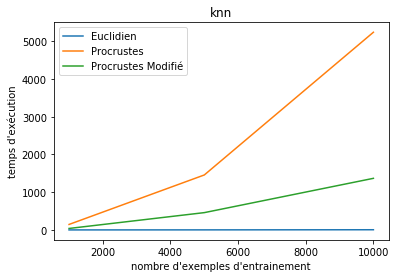

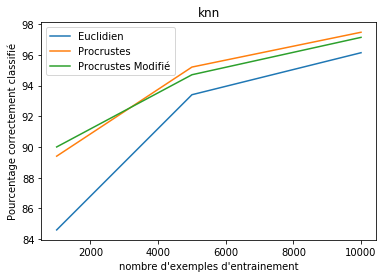

In [90]:
compare_plot(nb_exemples,knn_eu_times, knn_proc_times, knn_procm_times,
             "temps d'exécution", 'knn', "nombre d'exemples d'entrainement")

compare_plot(nb_exemples,knn_eu_results , knn_proc_results, knn_procm_results ,
             "Pourcentage correctement classifié", 'knn', "nombre d'exemples d'entrainement")

On peut voir que procrustes prend rapidement de plus en plus de temps à exécuter tandis que la version modifiée augmente d'une manière un peu plus proche d'un temps linéaire (malgré qu'elle ne soit pas non plus linéaire). Par exemple, procrustes prend 1 heure 27 minutes et 19 secondes à 10000 exemples tandis que la version modifiée prend seulement 22 minutes et 47 secondes. Pour ce qui est du temps d'exécution de la version euclidienne, elle n'augmente presque pas avec le nombre d'exemples. Elle prend environ 5 secondes à 10000 exemples.

Pour la performance par contre, la version euclidenne est la moins performante peu importe le nombre d'exemples (5.4%, 1.3% et 1% de différence entre la modifié et euclidienne à respectivement 1000, 5000 et 10000 exemples). On voit, cependant, qu'avec le nombre d'exemples augmentant, la différence de performance diminue, car ils s'approchent tous du plafond de 100%. Avec peu d'exemples, la différence entre procrustes et la version modifiée est en faveur de la version modifiée. Cependant, avec l'augmentation du nombre d'exemples, la différence diminue rapidement (0.6%, -0.5% et -0.334% de différence à respectivement 1000, 5000 et 10000 exemples)

##### Partition Binaire

#### K-medoids

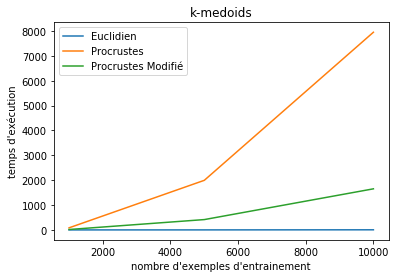

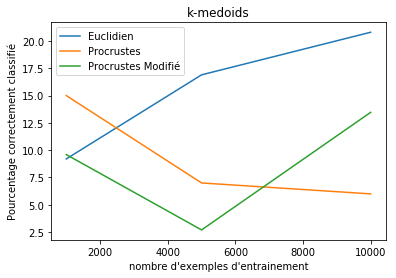

In [106]:
compare_plot(nb_exemples,kmedoids_eu_times, kmedoids_proc_times, kmedoids_procm_times,
             "temps d'exécution", 'k-medoids', "nombre d'exemples d'entrainement")

compare_plot(nb_exemples,kmedoids_eu_results , kmedoids_proc_results, kmedoids_procm_results,
             "Pourcentage correctement classifié", 'k-medoids', "nombre d'exemples d'entrainement")

On peut voir que, comme dans le cas avec kNN, procrustes prend rapidement de plus en plus de temps à exécuter tandis que la version modifiée augmente moins rapidement. Procrustes prend 2 heure 12 minutes et 27 secondes à 10000 exemples tandis que la version modifiée prend 27 minutes et 31 secondes et la version euclidienne prend seulement 5 secondes.

Pour la performance, procrustes a un pourcentage d'exemple correctment classifié qui diminue avec le nombre d'exemples qui augmente (15%, 7%, 6% à 1000, 5000, 10000). La performance de la version modifiée est très variable passant de 9.6% à 2.7%, puis elle remonte à 13.4667%. La distance euclidienne est définitivement meilleure étant donné qu'elle obtient dans les plus hauts résultats et ces résultats augmente avec le nombre d'exemples. Son taux passe 9.2% à 16.9%, puis augmente à 20.8% pour 10000 exemples.

#### PCoA

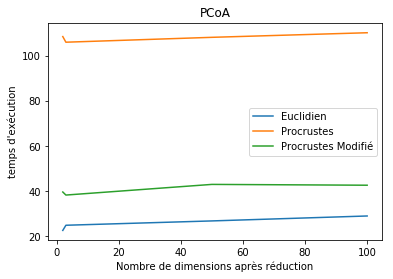

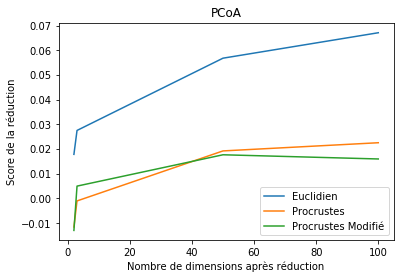

In [19]:
compare_plot(dims_pcoas,pcoa_eu_times, pcoa_proc_times, pcoa_procm_times,
             "temps d'exécution", 'PCoA', "Nombre de dimensions après réduction")

compare_plot(dims_pcoas,pcoa_eu_scores, pcoa_proc_scores, pcoa_procm_scores,
             "Score de la réduction", 'PCoA', "Nombre de dimensions après réduction")

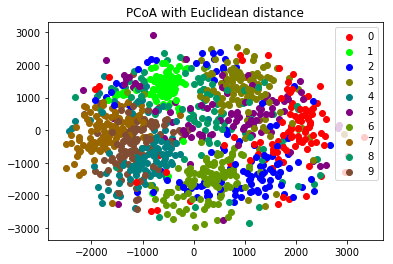

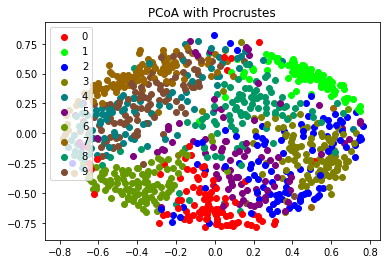

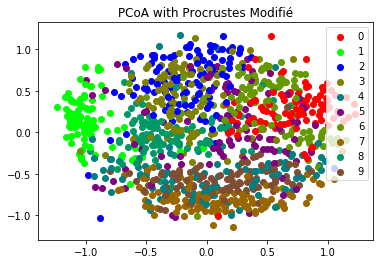

In [20]:
visualize_2d(pcoa_eu_visualize[0], "PCoA with Euclidean distance")
visualize_2d(pcoa_proc_visualize[0], "PCoA with Procrustes")
visualize_2d(pcoa_procm_visualize[0], "PCoA with Procrustes Modifié")

Pour le temps d'exécution, il y a peu de variance pour les différentes dimensions de l'espace réduite. La version modifiée à un temps maximum de 42 secondes ce qui n'est pas très loin du temps maximum de l'euclidienne (25 secondes). De plus, c'est une bonne amélioration comparée au temps de procrustes (105 secondes).

Pour la performance, visuellement dans le cas 3d,

#### Isomap 

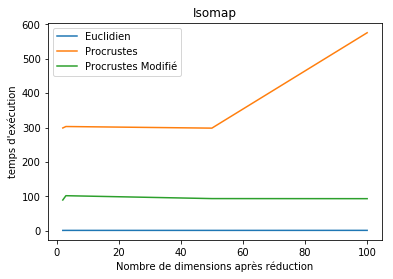

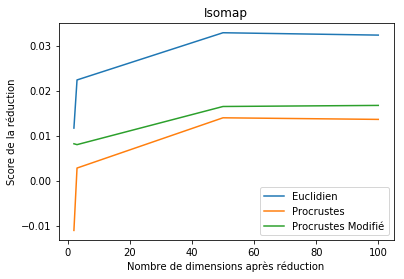

In [26]:
compare_plot(dims_isos,iso_eu_times, iso_proc_times, iso_procm_times,
             "temps d'exécution", 'Isomap', "Nombre de dimensions après réduction")

compare_plot(dims_isos,iso_eu_scores, iso_proc_scores, iso_procm_scores,
             "Score de la réduction", 'Isomap', "Nombre de dimensions après réduction")

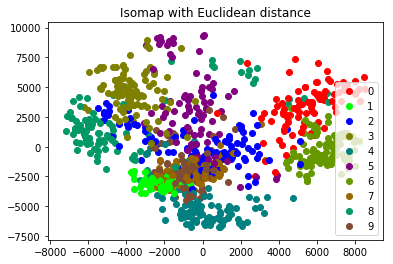

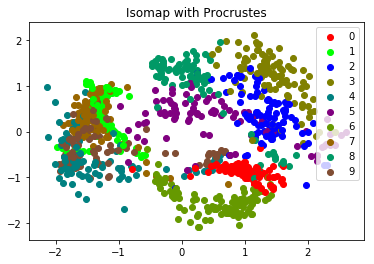

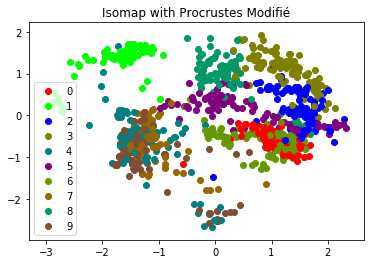

In [27]:
visualize_2d(iso_eu_visualize[0], 'Isomap with Euclidean distance')
visualize_2d(iso_proc_visualize[0], 'Isomap with Procrustes')
visualize_2d(iso_procm_visualize[0], 'Isomap with Procrustes Modifié')